# Plotting Fit Results

In [1]:
import ROOT
ROOT.ROOT.EnableImplicitMT() # REMOVE THIS WHEN DEBUGGING

import os
from typing import List
import argparse
import numpy as np
from pyamptools.utility.utils import remove_all_whitespace
from pyamptools.utility.plotgen_utils import book_histogram, turn_on_specifc_waveset, draw_histograms
from pyamptools import atiSetup

from IPython.display import Image

REPO_HOME     = os.environ['REPO_HOME']
atiSetup.setup(globals(), use_fsroot=True)

Welcome to JupyROOT 6.28/06
atiSetup| jupyter-lab called python3.9

------------------------------------------------
atiSetup| MPI is disabled
atiSetup| GPU is disabled
------------------------------------------------


atiSetup| Loading library libAmpTools.so ..............  ON
atiSetup| Loading library libAmpPlotter.so ............  ON
atiSetup| Loading library libAmpsDataIO.so ............  ON
atiSetup| Loading library libFSRoot.so ................  ON
atiSetup| Loading library libAmpsGen.so ...............  OFF


------------------------------------------------
Initializing AMPTOOLS_AMPS_DATAIO for PyROOT...
------------------------------------------------

Initializing FSRoot for PyROOT...


After performing a MLE fit a `FitResults` object is created with a `.fit` extension. This file can be read in using the `AmpTools` [PlotGenerator](https://github.com/mashephe/AmpTools/blob/master/AmpTools/IUAmpTools/PlotGenerator.h) class. In this class, Amplitudes can be turned on/off and amplitude weights can be extracted for a particular amplitude combination. These weights can then be used for plotting purposes. 

This tutorial will go over how we can use `FSRoot` and `RDataFrames` to produce fit results.

`Numpy` is used as an intermediary between `PlotGenerator` and `RDataFrame`. This choice is made so that users can makes plots in the Python ecosystem if they wish instead of going through `ROOT`. It is important to remark that `RDataFrame` does not perform any copying and reads directly from the `Numpy` array.

Some *macros* can be loaded ( mirroring `FSRoot` [macros](https://github.com/remitche66/FSRoot/blob/72959ffdc223546377c690873c7759e4e6b901a0/FSBasic/FSTree.h) / [math](https://github.com/remitche66/FSRoot/blob/master/FSBasic/FSMath.h) ) that calculates various kinematic quantites (i.e. *mass* and *helicity angles*). We can load them as follows. We will return to their definitions in a bit.

In [2]:
from pyamptools.utility.RDFmacros import loadMacros
loadMacros()

We can also use `PyROOT` to load headers files. Here we will load the `gluex_style` and set the plotting style

In [3]:
### IF USING ROOT TO PLOT - CAN SET GLUEX STYLE HERE ###
gInterpreter.ProcessLine('#include "gluex_style.h"')
gluex_style = ROOT.gluex_style() # Returns TStyle
gluex_style.SetPadRightMargin(0.08)
gluex_style.cd()

Lets set some additional alias and enable multi-threading for faster results

Lets define the location of the `.fit` file and the name of a `.pdf` file to dump drawn histograms to

In [5]:
fit_results = f'{REPO_HOME}/tests/samples/SIMPLE_EXAMPLE/result.fit'
hist_output_name = 'result' # dumps results to a pdf file with this name, extension will be appended

Lets load the `.fit` file into a `FitResults` object

In [6]:
results = FitResults( fit_results )
if not results.valid():
    print(f'Invalid fit result in file: {fit_results}')
    exit()

   |        ^                                                      |
   |       / \             Version:  v0.15.1-dirty                 |
   |      /---\                                                    |
   |     /     \           GDouble:  8 bytes                       |
   |    /       \ MP           MPI:  NO                            |
   |     -------               GPU:  NO                            |
   |        |                                                      |
   |        |              doi.org/10.5281/zenodo.5039377          |
   |        | OOLS                                                 |


As always, we have to register the requested amplitudes and the datareaders. We can then create a `PlotGenerator` instance. The order matters as `PlotGenerator` uses these amplitudes and datareaders.

In [7]:
AmpToolsInterface.registerAmplitude( Zlm() )
AmpToolsInterface.registerDataReader( DataReader() )

plotGen = PlotGenerator( results )


[ AmplitudeManager ]:

	Creating AmplitudeManager for the reaction:  etapi
		 particle index assignment:  Beam -> 0
		 particle index assignment:  Proton -> 1
		 particle index assignment:  Eta -> 2
		 particle index assignment:  Pi0 -> 3
Resetting source kin in /w/halld-scshelf2101/lng/WORK/PyAmpTools/tests/samples/SIMPLE_EXAMPLE/samples/data_generated_samples.root
Resetting source kin in /w/halld-scshelf2101/lng/WORK/PyAmpTools/tests/samples/SIMPLE_EXAMPLE/samples/flat_generated_samples.root
Resetting source kin in /w/halld-scshelf2101/lng/WORK/PyAmpTools/tests/samples/SIMPLE_EXAMPLE/samples/flat_generated_samples.root


We can book histograms in the dictionary format shown below. For now, we will just make 1D histograms of several kinematic quantities. We use macros inspired and using `FSRoot` format to compute quantities. The macros are defined in `utils/RDFmacros.py`, see [here for source code](https://github.com/lan13005/PyAmpTools/blob/main/utils/RDFmacros.py).

For example, `MASS(ETA,PI0)` would compute the invariant mass of the `ETA, PI0` system where `ETA` and `PI0` are defined `particles`. The order of the `particles` matters and should match what is seen in the configuration file.

In `RDataFrame`, histograms are first booked and lazily evaluated, to define as much computation as possible before a request for a result is made. 

In [8]:
############### BOOKEEPING ################
## START WITH 1D HISTS SO WE CAN REUSE FUNCTION VALUES! ##
## FOR THIS EXAMPLE, WILL NOT INCLUDE 2D PLOTS SO WE CAN STACK 1D HISTS FOR FIT RESULTS ##
HISTS_TO_BOOK = {
    # 1D Hists
    # HistName: [ xname, Function, title, n_bins, x-min, x-max, drawOptions]
    "Metapi": [ "Metapi", "MASS(ETA,PI0)", ";M(#eta#pi);Events", 50, 1.04, 1.72, "" ],
    "Meta":   [ "Meta", "MASS(ETA)", ";M(#eta);Events", 50, 0.49, 0.61, "" ],
    "Mpi0":   [ "Mpi0", "MASS(PI0)", ";M(#pi^{0});Events", 50, 0.1, 0.18, "" ],
    "cosGJ":  [ "cosGJ", "GJCOSTHETA(ETA,PI0,RECOIL)", ";cos(#theta_{GJ});Events", 50, -1, 1, "" ],
    "cosHel": [ "cosHel","HELCOSTHETA(ETA,PI0,RECOIL)", ";cos(#theta_{HEL});Events", 50, -1, 1, "" ],
    "phiHel": [ "phiHel","HELPHI(ETA,PI0,RECOIL,GLUEXBEAM)", ";#phi_{HEL};Events", 50, -1, 1, "" ],

    # 2D Hists
    # HistName:     [ xname, xfunction, title, nx_bins, x_min, x_max, yname, yfunction, ny_bins, y_min, y_max, drawOptions]
    # "cosHelvsMass": [ "Metapi", "MASS(ETA,PI0)", "M(#eta#pi) vs cos(#theta_{hel})", 100, 1.04, 1.72, "cosHel", "GJCOSTHETA(ETA,PI0,GLUEXBEAM)", 100, -1, 1, "COLZ"],
}

############## SETUP ##############
particles = ['GLUEXBEAM','RECOIL','ETA','PI0']


`draw_histograms` is an example implemenation of how to take the dictionary of histogram specification, fill histograms, and draw the result. See [draw_histograms API](https://lan13005.github.io/PyAmpTools/api/plotgen.html#PlotGenRDF.draw_histograms) for more information and source code. We can pass in an `amplitudes` string containing a space separated string of wavesets which are themselves semicolon separated list of amplitudes and draw them all.

In [9]:
amplitudes = "all resAmp1 resAmp2 resAmp3 resAmp1;resAmp2"
draw_histograms(results, hist_output_name, particles, HISTS_TO_BOOK, amplitudes)

 >> Plotting waveset: all
 >> Plotting waveset: resAmp1
 >> Plotting waveset: resAmp2
 >> Plotting waveset: resAmp3
 >> Plotting waveset: resAmp1;resAmp2
	Creating AmplitudeManager for the reaction:  etapi
		 particle index assignment:  Beam -> 0
		 particle index assignment:  Proton -> 1
		 particle index assignment:  Eta -> 2
		 particle index assignment:  Pi0 -> 3
Resetting source kin in /w/halld-scshelf2101/lng/WORK/PyAmpTools/tests/samples/SIMPLE_EXAMPLE/samples/data_generated_samples.root
Resetting source kin in /w/halld-scshelf2101/lng/WORK/PyAmpTools/tests/samples/SIMPLE_EXAMPLE/samples/flat_generated_samples.root
Resetting source kin in /w/halld-scshelf2101/lng/WORK/PyAmpTools/tests/samples/SIMPLE_EXAMPLE/samples/flat_generated_samples.root


Info in <TCanvas::Print>: png file result_all.png has been created
Info in <TCanvas::Print>: png file result_resAmp1.png has been created
Info in <TCanvas::Print>: png file result_resAmp2.png has been created
Info in <TCanvas::Print>: png file result_resAmp3.png has been created
Info in <TCanvas::Print>: png file result_resAmp1;resAmp2.png has been created


Overall Fit results

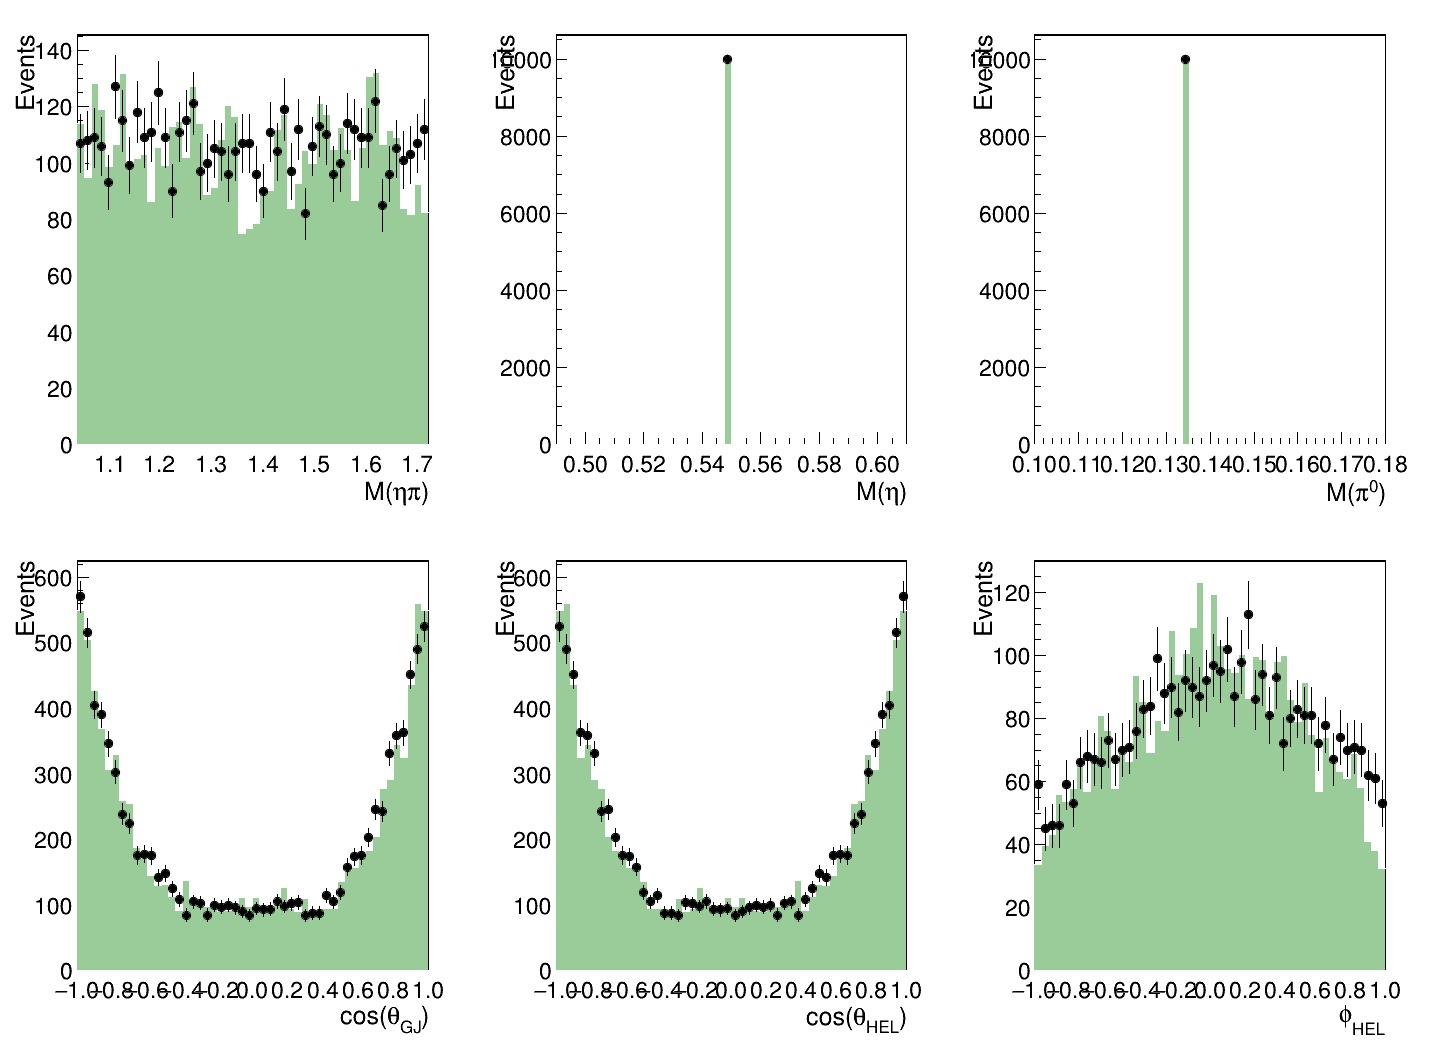

In [11]:
Image(filename=f'result_all.png')

Only the L=2 M=0 wave

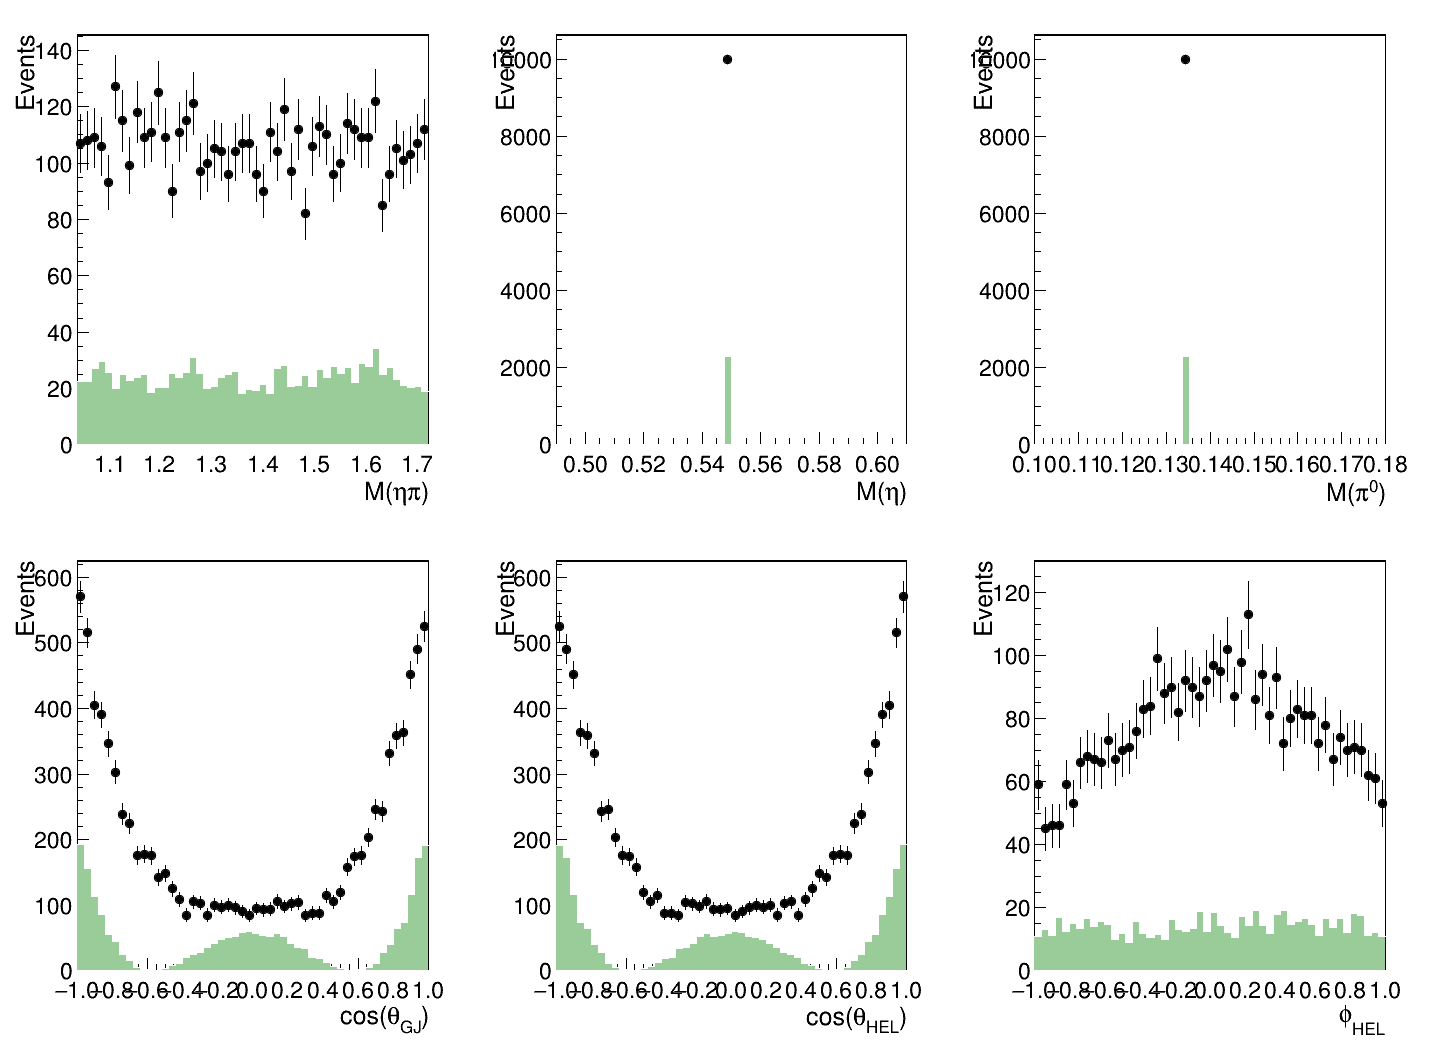

In [12]:
Image(filename=f'result_resAmp1.png')

Only the L=2 M=2 wave

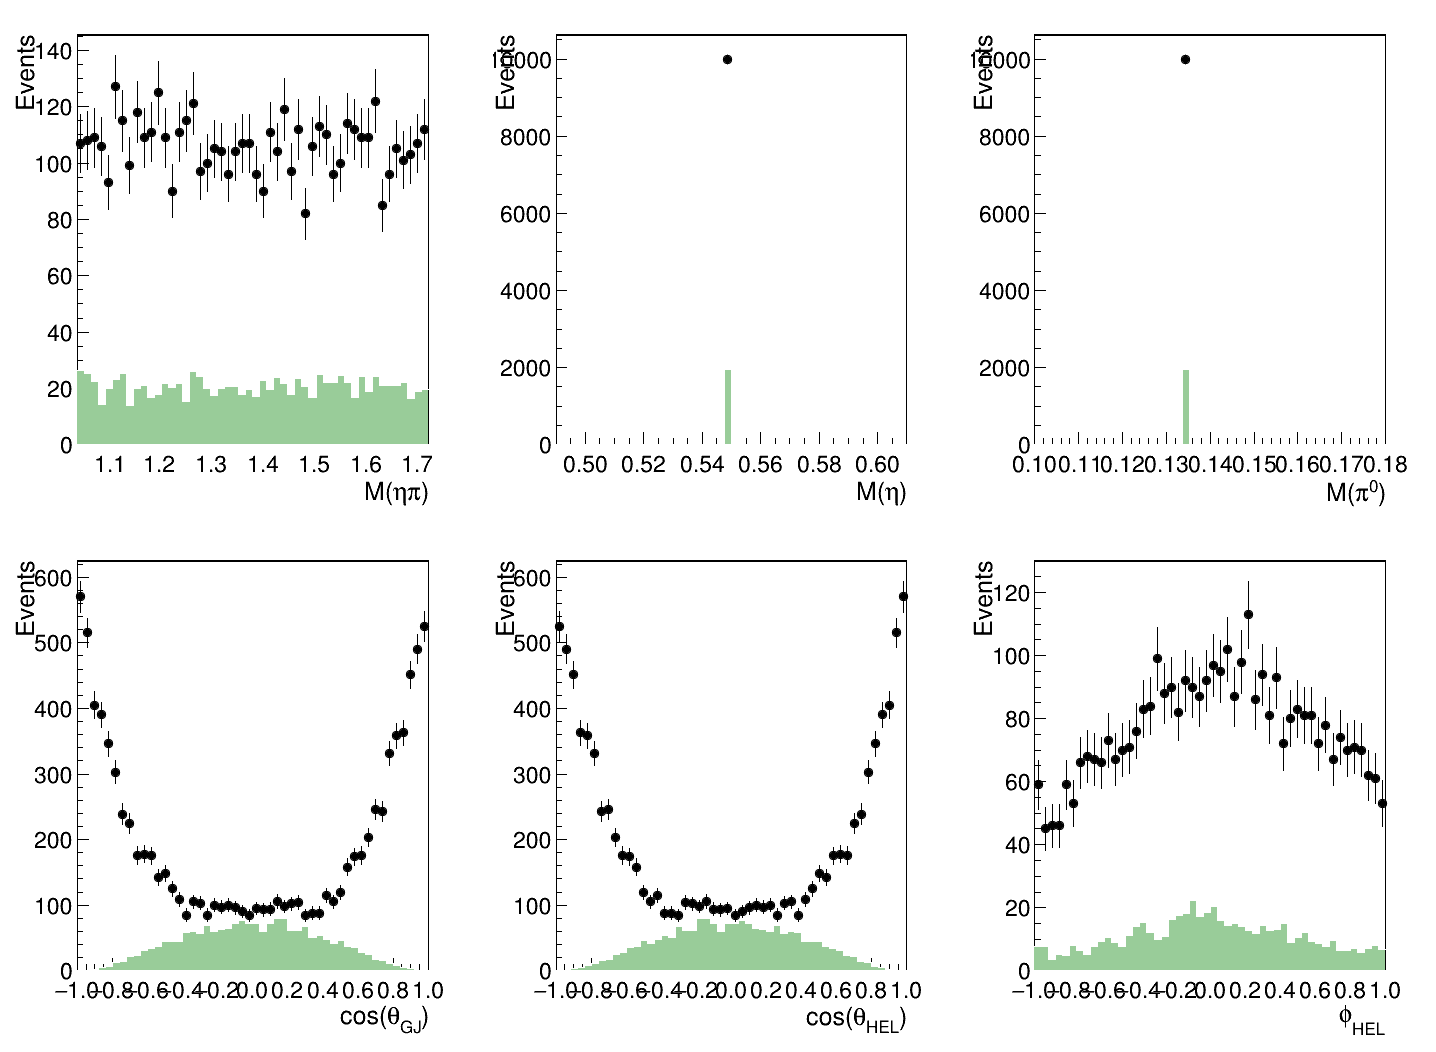

In [13]:
Image(filename=f'result_resAmp2.png')

Only the L=0 M=0 wave

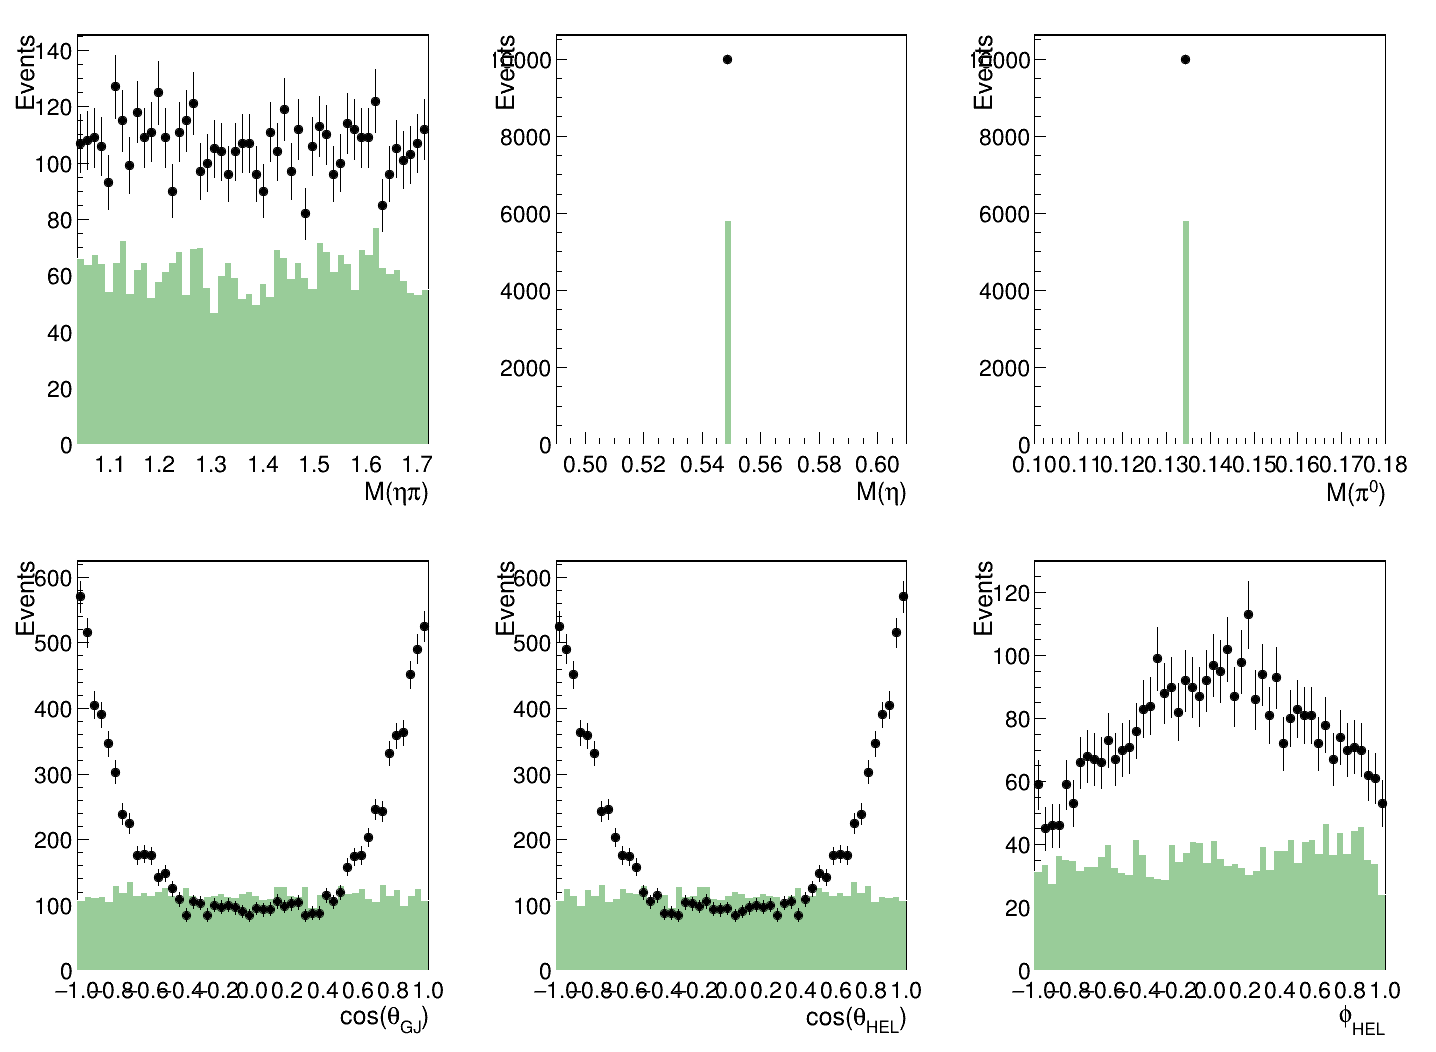

In [14]:
Image(filename=f'result_resAmp3.png')

Coherent sum of (L=2, M=0) (L=2, M=0) waves

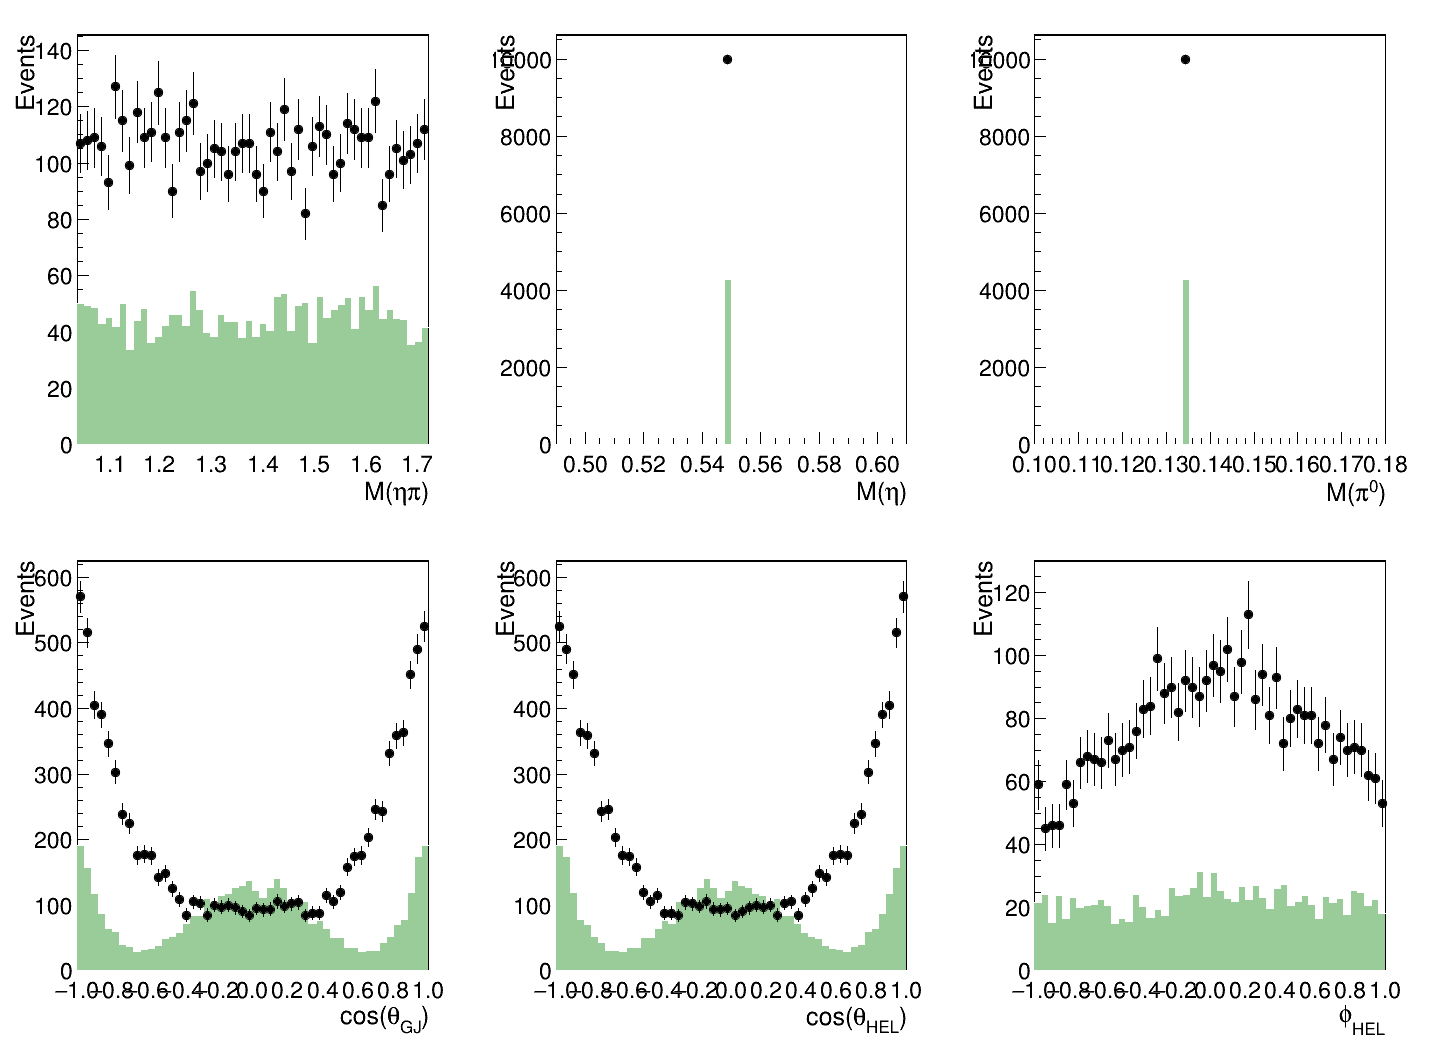

In [15]:
Image(filename=f'result_resAmp1;resAmp2.png')

In [16]:
# cleanup again
!rm result*.png